<img src="../docs/sa_logo.png" width="250" align="left">

# Text classification with HuggingFace BERT and SuperAnnotate



## Introduction

This tutorial shows an example of solving ```Text classification task``` with [SuperAnnotate](https://www.superannotate.com/) and [HuggingFace](https://huggingface.co/).

The main goal of this tutorial is to show how one could annotate some part of data with ```SuperAnnotate``` tools and then build a model with ```HuggingFace``` to automatically annotate the rest of data and upload new annotations to [SuperAnnotate platform](https://app.superannotate.com/). These automatically generated annotations may be additionaly checked and modified manually.

All the experiments described in this tutorial were done with [Ford Sentence Classification](https://www.kaggle.com/datasets/satishkumarmishra/ford-sentence-classifiaction-dataset) dataset.

The tutorial starts with the assumption that we have partially annotated dataset of image}s.
The data is stored on S3 bucket and splitted into two parts: 
* **train** (~30%) $-$ annotated data for training
* **unlabeled** (~70%) $-$ data that will be annotated by the model

These folders are connected with existing project on [SuperAnnotate platform](https://app.superannotate.com/) and train dataset has already been annotated manually. 

![](../docs/text_classification_bert/clf_folders.png)

![](../docs/text_classification_bert/labeled_texts.png)

In the examples below we used ```SuperAnnotate SDK```, ```Boto3 SDK``` and ```HuggingFace```. $\ $
Some parts of code used here are provided as examples in [SuperAnnotate](https://doc.superannotate.com/docs/getting-started), [Boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) and  [HuggingFace](https://huggingface.co/) documentations.

In this tutorial we will go through the following steps:

$\textbf{1.}$ [Environmental setup](#envin_setup)


$\textbf{1.1.}$ [User Variables Setup](#user_variables_setup)


$\textbf{1.2.}$ [Constants Setup](#constants_setup)


$\textbf{2.}$ [Load data](#load_data)


$\textbf{3.}$ [Download Labels from SA](#download_labels_from_SA)


$\textbf{4.}$ [Data preprocessing and Dataset implementation](#data_preprocessing)


$\textbf{5.}$ [Text Classification with BERT and Hugging Face](#text_classification)


$\textbf{6.}$ [Train model](#train_model)


$\textbf{7.}$ [Evaluate model](#evaluate_model)
       

$\textbf{8.}$ [Get predictions for new texts](#get_predictions)

       
$\textbf{9.}$ [Make annotations in SuperAnnotate format](#make_annotations_sa_format)


$\textbf{10.}$ [Upload new annotations to SA](#upload_new_annotations_to_sa)

In [ ]:
! pip install superannotate==4.4.7 #SA SDK installation
! pip install boto3 # install boto3 client
! pip install transformers # HuggingFace transformers

### 1.1. User Variables Setup
<a id='user_variables_setup'></a>

In [ ]:
#SuperAnnotate SDK token
SA_TOKEN = "ADD_YOUR_TOKEN"

In [ ]:
SA_PROJECT_NAME = "ADD_SUPERANNOTATE_PROJECT_NAME"

### 1.2. Constants Setup
<a id='constants_setup'></a>

In [1]:
import boto3
import numpy as np
import os
import torch
import pandas as pd
import seaborn as sns

from collections import defaultdict
from matplotlib import pyplot as plt
from textwrap import wrap
from torch.nn import functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from transformers import get_linear_schedule_with_warmup, BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from superannotate import SAClient

SuperAnnotate Python SDK functions work within the team scope of the platform, so a team-level authorization is required.

To authorize the package in a given team scope, get the authorization token from the team settings page.

In [ ]:
sa_client = SAClient(token=SA_TOKEN) ## SuperAnnotate client

Data that is shown on SuperAnnotate page is actually stored on AWS S3 Bucket.
Here we provide name of this bucket.

In [ ]:
BUCKET_NAME = "ADD_YOUR_BUCKET_NAME" # bucket where the data is stored

## 2. Load data
<a id='load_data'></a>

In [ ]:
#this dict will contain S3 paths to train and unlabeled files
data_links_dict = {'train': [],
                   'unlabeled': []}

#path to the folder containing files in S3 bucket
BUCKET_FOLDER_PATH = '/path/to/data/'

file_format = '.txt'
start_key = ''
max_keys = 1000

for subset_name in ['train', 'unlabeled']:
    while True:
        response = s3_client.list_objects_v2(Bucket=BUCKET_NAME,
                                             Prefix=f'{BUCKET_FOLDER_PATH}/{subset_name}/',
                                             StartAfter=start_key,
                                             MaxKeys=max_keys)
        objects = response['Contents']
        for obj in objects:
            path = obj['Key']
            if path.endswith(file_format):
                data_links_dict[subset_name].append(obj['Key'])
        start_key = objects[-1]['Key']
        if len(objects) < max_keys:
            start_key = ''
            break

In [ ]:
for subset_name in subset_names:
    print(f"Loading {subset_name} docs")
    save_dir = f'./{subset_name}_sa_docs'
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    for file_key in tqdm(data_links_dict[subset_name]):
        if not '.txt' in file_key:
            continue
        filename = os.path.basename(file_key)
        s3_client.download_file(Bucket=bucket_name, 
                                Key=file_key,
                                Filename=os.path.join(save_dir, filename))

In [ ]:
train_filenames = [os.path.basename(x) for x in data_links_dict['train']]

In [ ]:
train_texts = []
for filename in train_filenames:
    with open(os.path.join('./train_sa_docs', filename)) as f:
        train_texts.append(f.read())

## 3. Download Labels from SA
<a id='download_labels_from_SA'></a>

In [ ]:
annotations = sa_client.get_annotations(project=f"{SA_PROJECT_NAME}/train", 
                                        items=train_filenames)

labels = [a['instances'][0]['className'] for a in annotations]

Text(0.5, 0, 'Type')

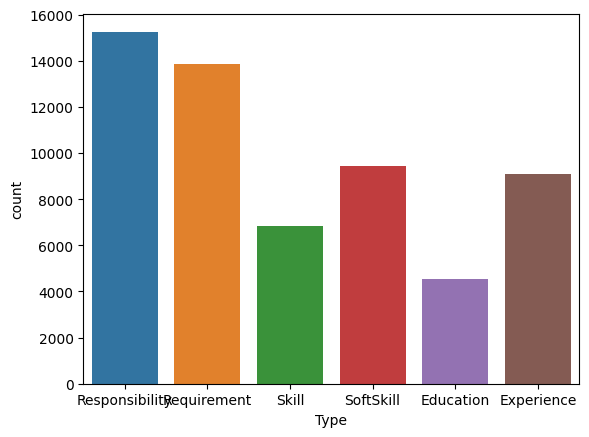

In [4]:
sns.countplot(x=labels)
plt.xlabel('Type')

## 4. Data preprocessing and Dataset implementation
<a id='data_preprocessing'></a>

Upload pre-trained tokenization model [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [5]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [6]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Set max sequence length equal to 512

In [7]:
MAX_LEN = 512

Now we will create PyTorch Dataset. We will use it to train our classification model.

In [8]:
class FordDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.texts)
  
    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(text,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation=True)
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long)}

We will split our labeled dataset into 3 parts: train, validation and test.

In [9]:
le = LabelEncoder()
labels_int = le.fit_transform(labels)
class_names = le.classes_

In [10]:
train_texts, test_texts, train_labels, test_labels = train_test_split(labeled_texts, labels_int, test_size=0.1)
val_texts, test_texts, val_labels, test_labels = train_test_split(test_texts, test_labels, test_size=0.5)

We will create iterators:
- train_data_loader - training data
- val_data_loader - validation data for training
- test_data_loader - data for model evaluation

In [11]:
def create_data_loader(texts, labels, tokenizer, max_len, batch_size):
    ds = FordDataset(texts=texts,
                     labels=labels,
                     tokenizer=tokenizer,
                     max_len=max_len)
    return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [12]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(train_texts[:1000], 
                                       train_labels[:1000], 
                                       tokenizer, 
                                       MAX_LEN, 
                                       BATCH_SIZE)
val_data_loader = create_data_loader(val_texts, 
                                     val_labels, 
                                     tokenizer, 
                                     MAX_LEN, 
                                     BATCH_SIZE)
test_data_loader = create_data_loader(test_texts, 
                                      test_labels, 
                                      tokenizer, 
                                      MAX_LEN, 
                                      BATCH_SIZE)

## 5. Text Classification with BERT and Hugging Face
<a id='text_classification'></a>


We will use basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and implement text classifier based on it.

In [13]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Now we can implement our text classifier based on BertModel.

In [14]:
class SentimentClassifier(torch.nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = torch.nn.Dropout(p=0.3)
        self.out = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids,
                                     attention_mask=attention_mask)
        
        pooled_output = bert_output[1]
        output = self.drop(pooled_output)
        return self.out(output)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 6. Train model
<a id='train_model'></a>

In [17]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

Implement a function for one epoch of training.

In [18]:
def train_epoch(model, 
                data_loader, 
                loss_fn, 
                optimizer, 
                device, 
                scheduler, 
                n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0
  
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

We should also implement model evalutation function.

In [19]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

Now we could implement model training loop.

In [20]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model,
                                        train_data_loader,    
                                        loss_fn, 
                                        optimizer, 
                                        device, 
                                        scheduler, 
                                        len(train_texts))

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model,
                                   val_data_loader,
                                   loss_fn, 
                                   device, 
                                   len(val_texts))

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/3
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss 1.3911898941993714 accuracy 0.009133537974802734


  0%|          | 0/369 [00:00<?, ?it/s]

Val   loss 0.9616454243659973 accuracy 0.001016949152542373

Epoch 2/3
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss 0.7962255320549011 accuracy 0.014011035573718009


  0%|          | 0/369 [00:00<?, ?it/s]

Val   loss 0.7112622261047363 accuracy 0.0016949152542372883

Epoch 3/3
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss 0.5943171257972717 accuracy 0.015329278168019435


  0%|          | 0/369 [00:00<?, ?it/s]

Val   loss 0.6146754622459412 accuracy 0.0016949152542372883

CPU times: user 5min 19s, sys: 2.65 s, total: 5min 21s
Wall time: 5min 22s


## 7. Evaluate model
<a id='evaluate_model'></a>

We can now implement function to get the prediction from the trained model.

In [21]:
def get_predictions(model, data_loader):
    model = model.eval()
  
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in tqdm(data_loader):

            texts = d["text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [22]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,
                                                               test_data_loader)

  0%|          | 0/369 [00:00<?, ?it/s]

Let's estimate model's performance on our test set.

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred, target_names=class_names))

                precision    recall  f1-score   support

     Education       0.81      0.70      0.75       246
    Experience       0.98      0.93      0.95       436
   Requirement       0.56      0.61      0.58       712
Responsibility       0.84      0.91      0.88       744
         Skill       0.60      0.37      0.45       353
     SoftSkill       0.62      0.71      0.66       460

      accuracy                           0.73      2951
     macro avg       0.73      0.70      0.71      2951
  weighted avg       0.73      0.73      0.72      2951



We can look at confusion matrix of predictions on the test set.

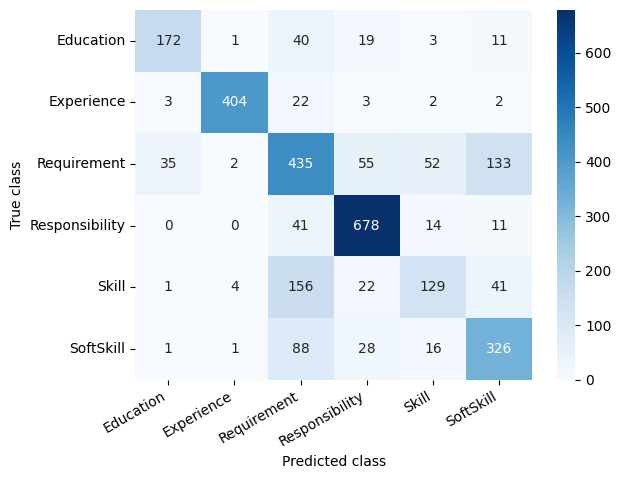

In [24]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True class')
    plt.xlabel('Predicted class');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## 8. Get predictions for new texts
<a id='get_predictions'></a>

Now we can get prediction for any new text.

In [ ]:
unlabeled_texts = []
for filename in train_filenames:
    with open(os.path.join('./unlabeled_sa_docs', filename)) as f:
        train_texts.append(f.read())

In [25]:
def predict_one_text(text, model, tokenizer, class_names):
    encoded_review = tokenizer.encode_plus(text,
                                           max_length=MAX_LEN,
                                           add_special_tokens=True,
                                           return_token_type_ids=False,
                                           padding='max_length',
                                           return_tensors='pt',
                                           truncation=True,
                                           return_attention_mask=True)
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    return class_names[prediction]

In [27]:
UNLABELED_TEXTS_FOLDER = ""

In [28]:
new_labels = [predict_one_text(text, model, tokenizer, class_names) for text in tqdm(unlabeld_texts)]

  0%|          | 0/10 [00:00<?, ?it/s]

## 9. Make annotations in SuperAnnotate format
<a id='make_annotations_sa_format'></a>

Based on predictions made by the model we should now create annotations in SuperAnnotate format to be able to upload them to SuperAnnotate.

In [29]:
ANNOTATIONS_FOLDER = "PUT_FOLDER_FOR_NEW_ANNOTATIONS_HERE"

In [ ]:
for label,filename in zip(new_labels, filenames):
    annotation = {"metadata": {"name": filename},
                  "instances": [{"type": "tag",
                                 "className": file2type[filename],
                                 "attributes": []}]}
    with open(os.path.join(ANNOTATIONS_FOLDER,filename)) as f:
        json.dump(annotation,f)

## 10. Upload new annotations to SA 
<a id='upload_new_annotations_to_sa'></a> 

Now we could upload annotations generated on the previous step back to SuperAnnnotate.

In [ ]:
def read_js(filename):
    with open(filename) as f:
        js = json.load(f)
    return js 

In [ ]:
outputs = []
files = os.listdir(ANNOTATIONS_FOLDER)
files_per_step = 500
steps = len(files) // files_per_step + 1

for step in range(steps):
    start = step * files_per_step
    end = min((step + 1)* files_per_step, len(files))

    batch = [read_js(os.path.join(ANNOTATIONS_FOLDER, f)) for f in files[start: end]]

    outputs.append(sa_client.upload_annotations(project=f'{SA_PROJECT_NAME}/unlabeled/', annotations=batch))

Now we can look at unlabeled folder at the SuperAnnotate page and see the predictions made by our model.


All files in unlabeled folder changed their status.

![](../docs/text_classification_bert/train_example.png)

We can open any of these files and check whether it is annitated correctly.

![](../docs/text_classification_bert/text_example.png)